In [82]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import sys
from shapely.geometry import Point,MultiPoint
GeoPy_path='/home/shashank/nobackup_shashank/gslib_executables/GeostatsPy/'
sys.path.insert(0, GeoPy_path)
import GeostatsPy
import os
#import rasterio 
from scipy import stats
from IPython.display import Image
#from pygeotools.lib import  iolib,geolib,warplib,malib
#import skgstat as skg
from scipy.optimize import curve_fit
from scipy.optimize import leastsq, fmin_slsqp,least_squares
import string
from multiprocessing import cpu_count, Pool

In [87]:
def min_dist_helper(shp_geom):
    """
    returns a coloumn with distance from nearest neighbour for each point
    """
    #geom = row.geometry
    shp = shp_geom[0]
    geom = shp_geom[1]
    dist = shp['geometry'].distance(geom).values
    min_dist = np.min(dist[np.nonzero(dist)])
    return min_dist
#something to consider in the future

In [88]:
def min_dist_calc(shp):
    """
    Calclates distance to nearest neighbour for points contained in a shapefile
    """
    with Pool(40) as p:
        geom_array = shp.geometry.values
        gdf_list_input = [shp]*len(shp)
        gdf_list_pass = list(zip(gdf_list_input,geom_array))
        out = p.map(min_dist_helper, [gdf for gdf in gdf_list_pass])
        # we should be fine with order, multiproc maintians order by default
    return out

In [89]:
#tpl is a tupple containing the (nugget,sill,range)
def spherical(X,tpl):
    #tpl[0] = nugget
    #tpl[1] = sill
    #tpl[2] = hrange
    i=0
    y=np.zeros(np.shape(X))#.reshape(1,)
    for x in X:
        if x==0.0:
            Y=0.0
        elif (x>0.0) & (x<=tpl[2]):
            Y=tpl[0]+tpl[1]*((3*x)/(2*tpl[2])-0.5*(x/tpl[2])*(x/tpl[2])*(x/tpl[2]))
        elif (x>tpl[2]):
            Y=tpl[0]+tpl[1]
        y[i]=Y#y.append(Y)
        i=i+1
    return y
error_func = lambda tpl,x,y: spherical(x,tpl)-y

In [90]:
def exponential(X,tpl):
    X = np.array(X)
    Y = tpl[0]+ tpl[1]*(1-np.exp(-(X/tpl[2])))
    return Y
error_func_exp = lambda tpl,x,y: exponential(x,tpl)-y

In [155]:

def vario_plt_ref(lag,gamma,lag_m,gamma_m,hrange,rgi_title,nugget,ax):
    """
    Simple Plotting function for variogram and modlled variogram
    """
    #fig,ax=plt.subplots(figsize=(8,8))
    ax.plot(lag,gamma,'r--',label='Experimental Variogram')
    ax.plot(lag_m,gamma_m,'g^',label='Modelled Variogram')
    y0,y1 = ax.get_ylim()
    #print(y0,y1)
    ax.axvline(x=hrange,color='blue',ymin=0,ymax=1)
    #print(np.max(np.array(gamma)))
    ax.set_xlabel('Lag Distance (m)')
    ax.set_ylabel('Variogram')
    hrange_round = np.round(hrange,decimals=2)
    nugget_round = np.round(nugget,decimals=2)
    title_str = '{} \n range of influence = {}m \n nugget = {} \n'.format(rgi_title,hrange_round,nugget_round)
    #title_str = rgi_title+' \n range of influence = '+'{0:.2f}'.format(hrange)+' m'
    ax.set_title(title_str)
    #ax.set_ylim(0,1)
    plt.legend()
    #return fig
    

In [152]:
def variogram_wrapper(df,z,nlags,lag_dist,max_sill=None):
    """
    wrapper fucntion which calculates experimental variogram and fits a model variogram to it
    """
    lag_experi,gamma_experi,npair_experi = GeostatsPy.gamv_2d(std_df,'x','y',z,nlags,lag_dist,0,90,1)
    tpl_init = (0,0.2,1000)
    if max_sill:
        max_gama = max_sill
    else:
        max_gama = np.max(gamma_experi)
    tpl_final_sph= least_squares(error_func,tpl_init[:],bounds=((0,0,0),(np.max(gamma_experi),max_gama,np.max(lag_experi))),args=(lag_experi,gamma_experi))
    lag_mod = lag_experi
    gamma_mod = spherical(lag_experi,tpl_final_sph.x)
    hrange_mod = tpl_final_sph.x[-1]
    nugget = tpl_final_sph.x[0]
    return lag_experi,gamma_experi,lag_mod,gamma_mod,hrange_mod,nugget

# Note on how optimum lag distance can be computed 
- Analysis shows that result is dependent on the choice of lag distance
- Based on the reccommendations, we chose the lag distance as the mean/median of the nearest neighbour distances
- This is attempted on glacier centroids with Python multiprocessing utility (which nakes it possible to do it for ~95 k points)

In [93]:
csv_fn = './mb_20190213/hma_mb_20190214_1015_nmad.csv'
std_df = pd.read_csv(csv_fn)
std_df.head(2)

,RGIId,x,y,z_med,z_min,z_max,z_slope,z_aspect,dhdt_ma,dhdt_ma_sigma,...,t1,t2,dt,valid_area_perc,H_m,debris_m,perc_debris,perc_pond,perc_clean,vm_ma
0,14.06629,-747305.504,11409.822,7821.871,7707.358,7925.199,58.563,71.159,-1.141,1.319,...,2000.412,2018.412,18.0,97.820,NaN,NaN,NaN,NaN,NaN,NaN
1,15.05152,-145758.234,-820691.042,7818.454,7435.899,8144.735,36.931,25.958,0.588,0.549,...,2000.412,2018.412,18.0,99.985,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
std_df.keys()

Index(['RGIId', 'x', 'y', 'z_med', 'z_min', 'z_max', 'z_slope', 'z_aspect',
       'dhdt_ma', 'dhdt_ma_sigma', 'mb_mwea', 'mb_mwea_sigma', 'area_m2',
       'mb_m3wea', 'mb_m3wea_sigma', 't1', 't2', 'dt', 'valid_area_perc',
       'H_m', 'debris_m', 'perc_debris', 'perc_pond', 'perc_clean', 'vm_ma'],
      dtype='object')

In [95]:
std_df_short = std_df[['RGIId','x','y','mb_m3wea_sigma']]

In [96]:
std_df['geometry'] = list(zip(std_df.x,std_df.y))
std_df['geometry'] = std_df['geometry'].apply(Point)
dummy_crs = gpd.read_file('/home/shashank/data/rgi60/regions/rgi60_merge_CONUS_aea.shp').crs
std_gdf = gpd.GeoDataFrame(std_df,geometry='geometry',crs=dummy_crs)

In [97]:
std_gdf.head()

,RGIId,x,y,z_med,z_min,z_max,z_slope,z_aspect,dhdt_ma,dhdt_ma_sigma,...,t2,dt,valid_area_perc,H_m,debris_m,perc_debris,perc_pond,perc_clean,vm_ma,geometry
0,14.06629,-747305.504,11409.822,7821.871,7707.358,7925.199,58.563,71.159,-1.141,1.319,...,2018.412,18.0,97.820,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-747305.5040000001 11409.822)
1,15.05152,-145758.234,-820691.042,7818.454,7435.899,8144.735,36.931,25.958,0.588,0.549,...,2018.412,18.0,99.985,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-145758.234 -820691.042)
2,15.02790,305153.261,-927260.154,7688.865,7324.962,7822.692,17.832,65.674,0.002,0.175,...,2018.412,18.0,99.931,NaN,NaN,NaN,NaN,NaN,NaN,POINT (305153.261 -927260.1540000001)
3,15.02793,307937.214,-927265.323,7687.291,7387.414,8068.165,31.805,321.875,0.105,0.422,...,2018.412,18.0,98.797,NaN,NaN,NaN,NaN,NaN,NaN,POINT (307937.214 -927265.323)
4,15.02827,308784.358,-927669.239,7683.328,7140.852,8151.286,44.873,95.269,1.276,1.870,...,2018.412,18.0,100.708,NaN,NaN,NaN,NaN,NaN,NaN,POINT (308784.358 -927669.2390000001)


# Note (Time hogger) 
- THE neigherest neighbour distance calculation takes some time to calculate. I am knowingly commenting it here and alloting the values I obtained from running this. Biggest time consuming block.

In [98]:
#std_gdf['min_dist'] = min_dist_calc(std_gdf)

In [100]:
std_gdf['min_dist'].mean()

923.835579816138

In [165]:
std_gdf['min_dist'].median()

786.4773252363802

In [119]:
median_near_neig = std_gdf['min_dist'].median()

In [118]:
mean_near_neig = std_gdf['min_dist'].mean()

In [ ]:
median_near_neig = 786.4773252363802
mean_near_neig = 923.835579816138

# Note on lag distance and number of lag used
- we fix lag distance at median nearest neighbour distance, no of lags at 80, so total spatial distance modeled = 786.477 *100 = ~79 km

- this is an omnidirectional variogram search (0 to 90 degree search for pairs)


# max allowed model sill is maximum gamma from experimental variogram

<IPython.core.display.Javascript object>


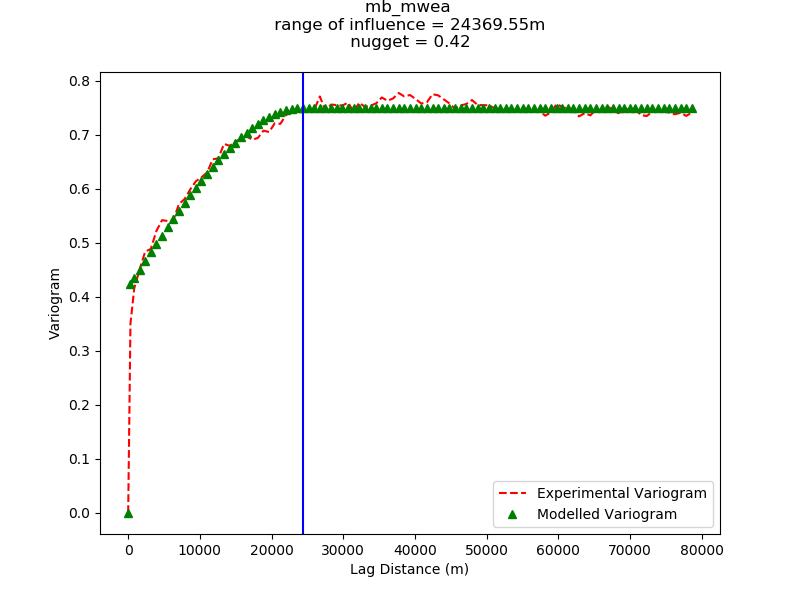

In [156]:
#mass balance variable
z = 'mb_mwea'
nlags = 100
#lag_dist = mean_near_neig
lag_dist = median_near_neig
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget = variogram_wrapper(std_df,z,nlags,lag_dist)
fig,axa = plt.subplots(figsize=(8,6))
vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa)

In [154]:
nugget

0.4182821949415497

<IPython.core.display.Javascript object>


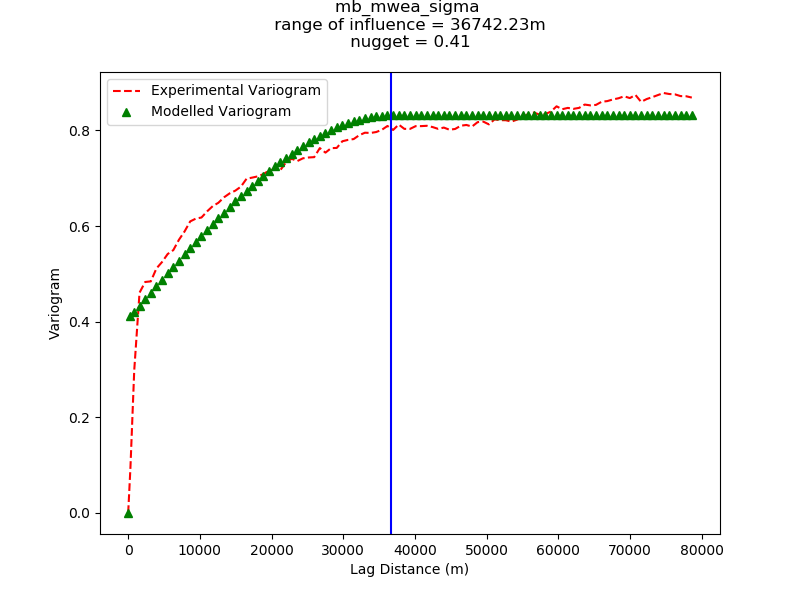

In [158]:
#mass balance std variable
z = 'mb_mwea_sigma'
nlags = 100
#lag_dist = mean_near_neig
lag_dist = median_near_neig
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget = variogram_wrapper(std_df,z,nlags,lag_dist)
fig,axa = plt.subplots(figsize=(8,6))
vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa)

<IPython.core.display.Javascript object>


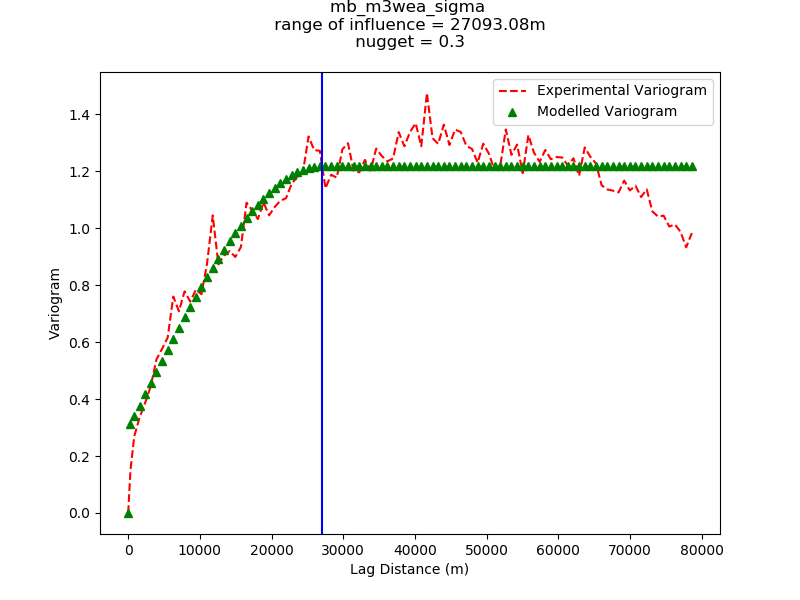

In [164]:
#volume balance std variable
z = 'mb_m3wea_sigma'
nlags = 100
#lag_dist = mean_near_neig
lag_dist = median_near_neig
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget = variogram_wrapper(std_df,z,nlags,lag_dist)
fig,axa = plt.subplots(figsize=(8,6))
vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa)

<IPython.core.display.Javascript object>


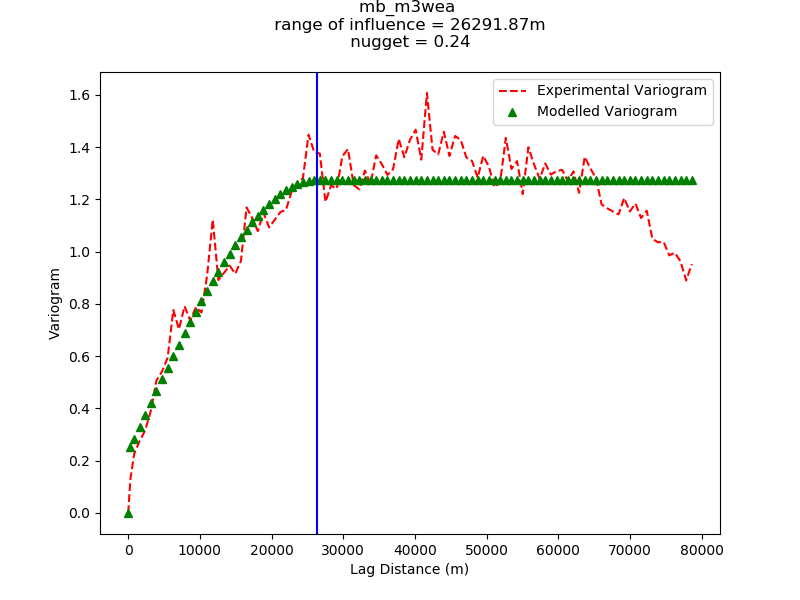

In [163]:
#volume balance variable
z = 'mb_m3wea'
nlags = 100
#lag_dist = mean_near_neig
lag_dist = median_near_neig
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget = variogram_wrapper(std_df,z,nlags,lag_dist)
fig,axa = plt.subplots(figsize=(8,6))
vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa)

# now modelling with maximum allowable sill at 1.0

<IPython.core.display.Javascript object>


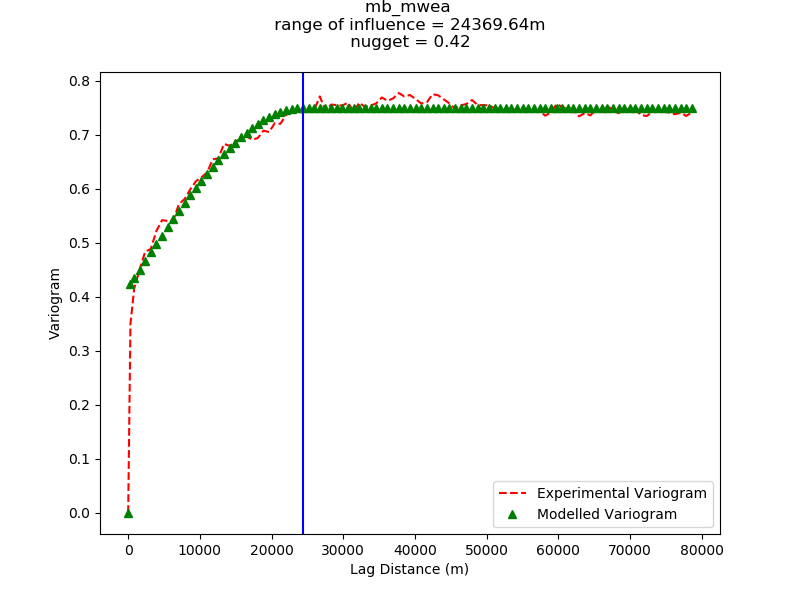

In [159]:
#mass balance variable
z = 'mb_mwea'
nlags = 100
#lag_dist = mean_near_neig
lag_dist = median_near_neig
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget = variogram_wrapper(std_df,z,nlags,lag_dist,1)
fig,axa = plt.subplots(figsize=(8,6))
vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa)

<IPython.core.display.Javascript object>


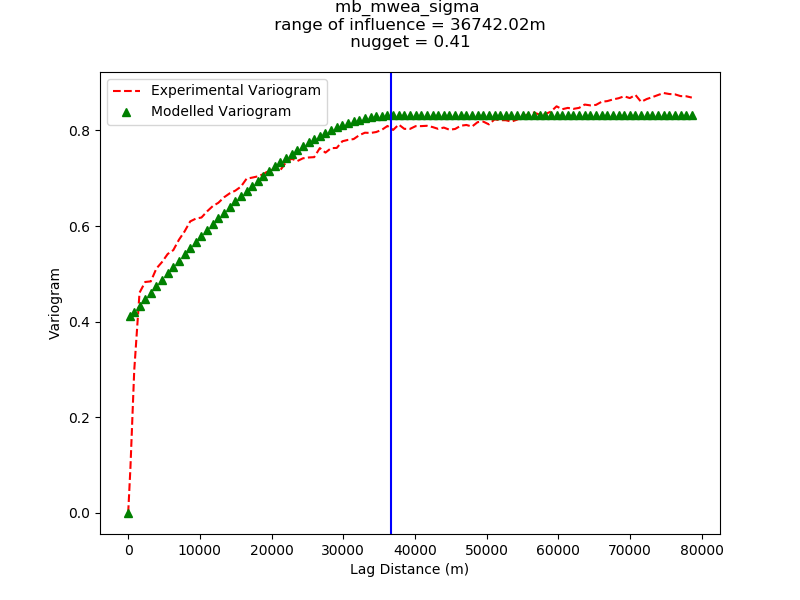

In [161]:
#mass balance std variable
z = 'mb_mwea_sigma'
nlags = 100
#lag_dist = mean_near_neig
lag_dist = median_near_neig
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget = variogram_wrapper(std_df,z,nlags,lag_dist,1)
fig,axa = plt.subplots(figsize=(8,6))
vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa)

<IPython.core.display.Javascript object>


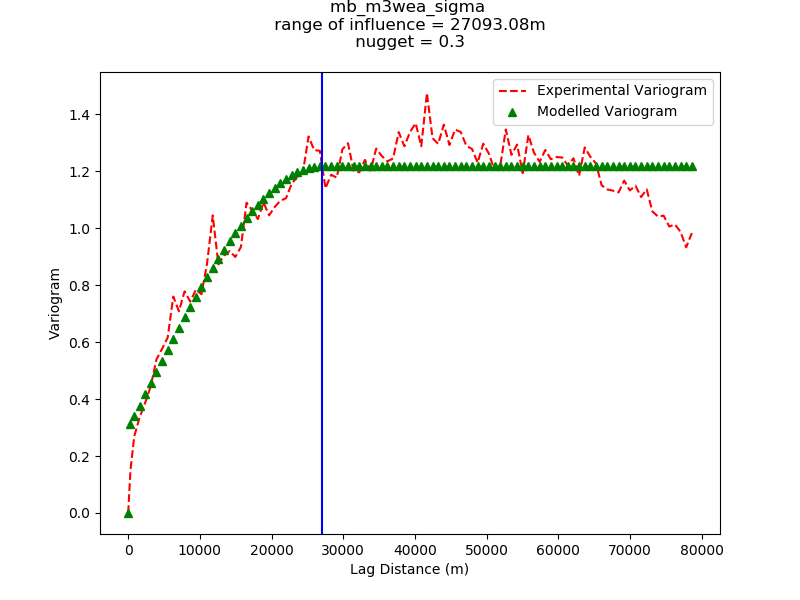

In [160]:
#volume balance std variable
z = 'mb_m3wea_sigma'
nlags = 100
#lag_dist = mean_near_neig
lag_dist = median_near_neig
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget = variogram_wrapper(std_df,z,nlags,lag_dist,1)
fig,axa = plt.subplots(figsize=(8,6))
vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa)

<IPython.core.display.Javascript object>


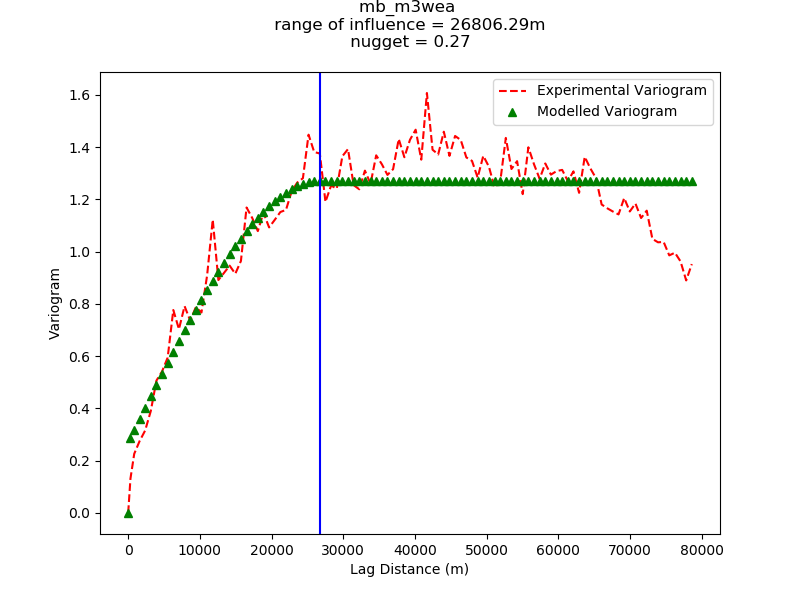

In [162]:
#volume balance variable
z = 'mb_m3wea'
nlags = 100
#lag_dist = mean_near_neig
lag_dist = median_near_neig
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget = variogram_wrapper(std_df,z,nlags,lag_dist,1)
fig,axa = plt.subplots(figsize=(8,6))
vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa)

# Resource for interpretation:

- https://pdfs.semanticscholar.org/b14e/e3aee4eb1588b94ad1b84a588567d45f6976.pdf (In a more geological sense)

- Rolstad et al. 2009 https://www.cambridge.org/core/journals/journal-of-glaciology/article/spatially-integrated-geodetic-glacier-mass-balance-and-its-uncertainty-based-on-geostatistical-analysis-application-to-the-western-svartisen-ice-cap-norway/FDEA8679441059F0BA18E932F8710FBF

- Magnússon et al. 2016 https://www.the-cryosphere.net/10/159/2016/tc-10-159-2016.pdf

# Interpretation
- The high nugget effect we see here shows that there is small scale variability here
- Glaciers located very close to each other vary very independtly and randomly
- Glacier mass balance, volume balance and uncertainty have range of influence around 25 km
- Glacier mass balance uncertainty `mb_mwea_sigma` has a higher range of influence `36.7 km`
- Need to think over this, I think something interesting is going on